# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.backends.backend_pdf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import scanpy as sc
import anndata as ad
import tangram as tg
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
np.random.seed(10)

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,5]

In [3]:
import torch
torch.cuda.empty_cache()
device = torch.device("cpu")

# Load data

In [4]:
running_data = None
running_data = '2celltypes'

## Reference data

In [5]:
reference = pd.read_csv("data/merfish/markerGene_for_merfish_data.csv")
reference.drop(columns=['p_value'], inplace=True)
# reference.drop(range(148,168))
reference.drop(reference.index[reference.cell_type=='EpendymalInhibitory'].tolist(), inplace=True)
reference['cell_type'] = reference['cell_type'].astype(str).str.replace(" ", "")
reference.head()

,cell_type,marker_gene
0,Astrocyte,Aldh1l1
1,Astrocyte,Aqp4
2,Astrocyte,Cxcl14
3,Astrocyte,Mlc1
4,Astrocyte,Ttyh2


## Spatial data

In [6]:
if running_data != '2celltypes':
    df_st = pd.read_csv("data/merfish/merfishSpatial.csv", sep=" ")
else:
    df_st = pd.read_csv("data/twoType/spatialData/" + "AstrocyteInhibitory" + "Spatial.csv", sep=",")
coords = df_st['coord']
df_st.drop(columns=['coord'], inplace=True)
df_st.head()

,Ace2,Adora2a,Aldh1l1,Amigo2,Ano3,Aqp4,Ar,Arhgap36,Avpr1a,Avpr2,...,Sln,Sst,Tac1,Tac2,Th,Trh,Ucn3,Vgf,Astrocyte,Inhibitory
0,0.0,0.0,24.042835,7.490070,0.000000,43.764002,0.0,7.061948,0.000000,0.0,...,0.00000,0.0,0.000000,0.016809,0.566421,0.000000,0.009827,0.018258,1.0,1.0
1,0.0,0.0,18.998619,18.594585,0.630872,40.359521,0.0,3.154416,1.261778,0.0,...,0.06346,0.0,0.072791,0.000000,0.562883,0.000000,0.003225,0.018325,1.0,1.0
2,0.0,0.0,20.779869,12.360754,0.000000,41.509898,0.0,3.562470,0.000000,0.0,...,0.00000,0.0,0.048410,0.000000,0.521170,0.000000,0.003225,0.008280,1.0,1.0
3,0.0,0.0,18.998619,3.454716,0.000000,39.728649,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.000000,0.000000,0.541505,0.014588,0.019870,0.000000,1.0,1.0
4,0.0,0.0,26.470893,3.454716,0.000000,57.875616,0.0,1.067474,0.533734,0.0,...,0.00000,0.0,0.000000,0.000000,0.510875,0.004664,0.024305,0.000000,1.0,1.0


In [7]:
genes = df_st.columns[:155]
markers = reference.groupby('cell_type').agg(list).marker_gene
celltypes = reference.cell_type.unique().tolist()
if running_data == '2celltypes':
    celltypes = df_st.columns[-2:]
expressions = df_st.drop(columns=celltypes)
expressions = MinMaxScaler().fit_transform(expressions)
counts_st = pd.DataFrame(expressions, columns=genes)
cellcount = pd.DataFrame(np.sum(df_st[celltypes], axis=1), columns=['cellcount']).astype(int)
typeCountDf = df_st[celltypes].astype(int)
typeCountDf.head()

,Astrocyte,Inhibitory
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [8]:
zero = (cellcount==0).sum()
print('zero count is',zero)

zero count is cellcount    0
dtype: int64


## Single-cell data

In [9]:
if running_data != '2celltypes':
    df_sc = pd.read_csv("data/merfish/merfishVisium.csv")
else:
    df_sc = pd.read_csv("data/twoType/singleCell/" + celltypes[0] + celltypes[1] + "Single.csv")
df_sc.head(2)

,Cell_ID,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID,Ace2,...,Penk,Scg2,Sln,Sst,Tac1,Tac2,Th,Trh,Ucn3,Vgf
0,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.273327,0.0,0.003225,0.0
1,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.273327,0.0,0.003225,0.0


In [10]:
counts_sc = df_sc[genes]
obs_sc = df_sc[[x for x in df_sc.columns if x not in genes]]
obs_sc.head()

,Cell_ID,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID
0,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
1,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
2,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
3,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
4,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN


In [11]:
cellTypeColumn = df_sc["Cell_class"].to_numpy()
assert set(np.unique(cellTypeColumn)) == set(celltypes), "cellTypeColumn contains unknown celltype"

# Tangram

In [12]:
adata_sc = ad.AnnData(counts_sc)
adata_st = ad.AnnData(counts_st, obs=cellcount)
print(adata_sc.shape)
print(adata_st.shape)

(1260, 155)
(251, 155)


In [13]:
adata_st.obs.head()
zeroCount=(obs_sc["Cell_class"]==0).sum()
zeroCount

0

In [14]:
tg.pp_adatas(adata_sc, adata_st, genes=None)

INFO:root:139 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:139 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [15]:
# adata_map_rna = tg.map_cells_to_space(adata_sc, adata_st, device=device, num_epochs=500)

In [16]:
adata_map_cellcount = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    target_count=adata_st.obs.cellcount.sum(),
    density_prior=np.array(adata_st.obs.cellcount) / adata_st.obs.cellcount.sum(),
    device=device,
    num_epochs=500
)
probabilityDf = adata_map_cellcount.to_df()

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 139 genes and customized density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.832, KL reg: 0.057
Score: 0.999, KL reg: 0.000
Score: 0.999, KL reg: 0.000
Score: 1.000, KL reg: 0.000
Score: 1.000, KL reg: 0.000


INFO:root:Saving results..


In [17]:
probabilityDf.sum(axis=1).round().unique()

array([1.], dtype=float32)

In [18]:
probabilityDf.drop('Cell_class', axis=1, inplace=True, errors='ignore')
n_cells, n_spots = probabilityDf.shape
predictions = np.zeros((n_cells))
for i in range(n_cells):
    predictions[i] = probabilityDf.iloc[i].argmax()

# Probability analysis

In [19]:
Nrows = len(df_st)
Ncols = len(celltypes)
print(Nrows, Ncols)
probabilityDf["Cell_class"]=cellTypeColumn
# print(probabilityDf["Cell_class"])

df_prediction = pd.DataFrame(np.zeros((Nrows,Ncols)),columns=celltypes)
tempDf = probabilityDf.copy()

for i in range(Nrows):
    tempDf = tempDf.sort_values(by=[str(i)], ascending=False)
    
    for  j in range(cellcount.iloc[i,0]):
        cellClass = tempDf.iloc[j]["Cell_class"]
        df_prediction.iloc[i][cellClass]+=1

df_prediction = df_prediction.astype(int)
deconvolveDf = df_prediction.copy()

251 2


In [20]:
probabilityDf.drop('Cell_class', axis=1, inplace=True, errors='ignore')

np.argmax(probabilityDf.iloc[2])
# probabilityDf.iloc[2,1247]

Nrows = len(df_st)
Ncols = len(celltypes)

df_prediction = pd.DataFrame(np.zeros((Nrows,Ncols)),columns=celltypes)
for i in range(len(probabilityDf)):
    spotNo = np.argmax(probabilityDf.iloc[i])
    cellClass = obs_sc.loc[i,"Cell_class"]
    df_prediction.loc[spotNo,cellClass] = df_prediction.loc[spotNo,cellClass] + 1


df_prediction = df_prediction.astype(int)
deconvolveDf = df_prediction.copy()
df_prediction.shape

(251, 2)

In [21]:
for i in range(len(df_prediction)):
    deconvolveDf.iloc[i] = 100 * df_prediction.iloc[i]/df_prediction.iloc[i].sum()

In [22]:
deconvolveDf.to_csv("tangramDeconvolved.csv",index= False)
deconvolveDf.isnull().sum(axis = 0)

Astrocyte     1
Inhibitory    1
dtype: int64

# Spatial data exploration

In [23]:
cnt_ = 0
for j in range(deconvolveDf.shape[1]):
    for i in range(deconvolveDf.shape[0]):
        # if celltype-specific cellcount is zero and deconvolution percentage > threshold
        if typeCountDf.iloc[i,j] == 0 and deconvolveDf.iloc[i,j] > 25:
            print(cellcount.iloc[i][0], deconvolveDf.columns[j], deconvolveDf.iloc[i,j])
            cnt_ += 1
            if cnt_ > 10:
                break

In [24]:
cellcount.value_counts()

cellcount
4            100
6            100
2             25
8             25
10             1
dtype: int64

# TANGRAM mispredictions

In [25]:
l = np.max(cellcount.values) + 1
count_misprediction = dict.fromkeys(celltypes)
for i in count_misprediction:
    count_misprediction[i] = dict.fromkeys(range(l))
    for j in count_misprediction[i]:
        count_misprediction[i][j] = [0, 0, dict.fromkeys(celltypes,0)]

for j in range(df_prediction.shape[1]):
    for i in range(df_prediction.shape[0]):
        actual_count = typeCountDf.iloc[i,j]
        predicted_count = df_prediction.iloc[i,j]
        tarr = count_misprediction[df_prediction.columns[j]][typeCountDf.iloc[i,j]]
        tarr[0] += 1
        if typeCountDf.iloc[i,j] != df_prediction.iloc[i,j]:
            tarr[1] += 1
            tarr[2] = {k: tarr[2].get(k, 0) + typeCountDf.iloc[i,:].to_dict().get(k, 0) \
                       for k in tarr[2].keys() | typeCountDf.iloc[i,:].to_dict().keys()}

Plotting for each celltype the number of spots with mispredictions

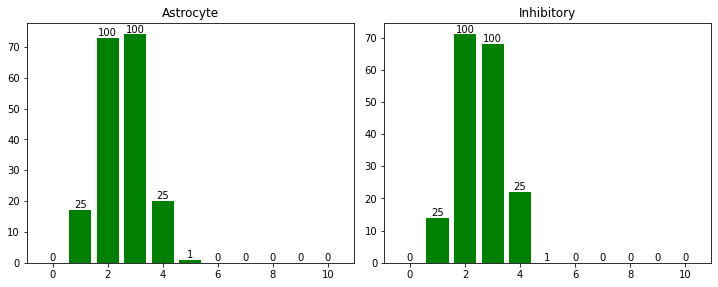

In [26]:
plt.rcParams['figure.figsize'] = [20,15]

for i, celltype in enumerate(celltypes):
    x = list(count_misprediction[celltype].keys())
    y = np.array(list(count_misprediction[celltype].values()))
    plt.subplot(4, 4, i+1)
    bar = plt.bar(x, y[:,1], width=0.8, color='g')
    for j, rect in enumerate(bar):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{y[j,0]:.0f}', ha='center', va='bottom')
    plt.title(celltype)
    plt.tight_layout()
    
plt.rcParams['figure.figsize'] = [10,5]

Plotting for each celltype the percentage of spots with mispredictions

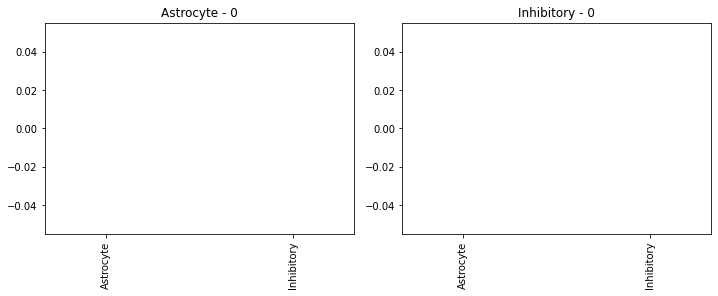

In [27]:
maxcellcount = len(count_misprediction[celltypes[0]].keys())
maxcellcount = 1

plt.rcParams['figure.figsize'] = [20, 15*maxcellcount]

j=0
for j in range(maxcellcount):
    for i, celltype in enumerate(celltypes):
        x = list(count_misprediction[celltype][j][2].keys())
        y = np.array(list(count_misprediction[celltype][j][2].values()))
        plt.subplot(4*maxcellcount, 4, j*16+i+1)
        bar = plt.bar(x, y, width=0.5, color='g')
        plt.xticks(rotation=90)
        # plt.ylim((0,100))
        plt.title(celltype + " - " + str(j))
        plt.tight_layout()
    
plt.rcParams['figure.figsize'] = [10,5]

# Fraction to cellcount ratio

In [28]:
df_fraction = df_prediction.divide(df_prediction.sum(axis=1), axis=0)
df_fraction['Cellcount'] = typeCountDf[celltypes[0]]
df_fraction.head()

,Astrocyte,Inhibitory,Cellcount
0,0.333333,0.666667,1
1,0.000000,1.000000,1
2,0.666667,0.333333,1
3,1.000000,0.000000,1
4,0.666667,0.333333,1


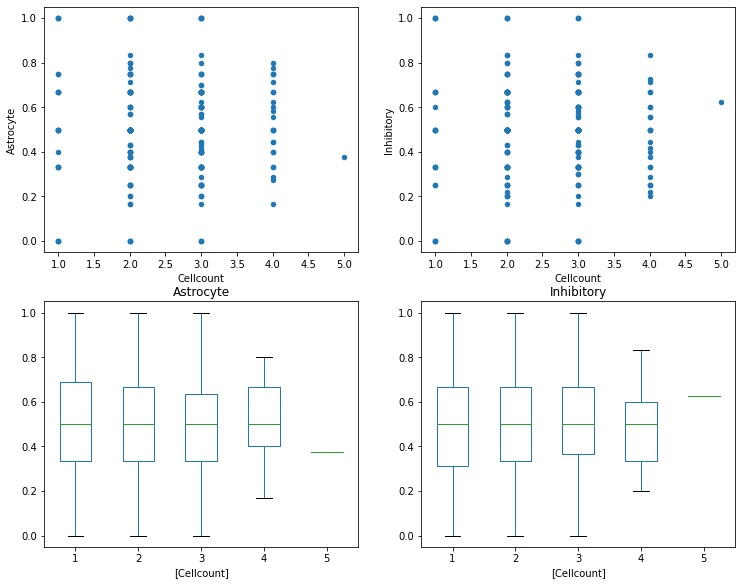

In [48]:
fix, axs = plt.subplots(2, len(celltypes), figsize=(12, 10))

for i, celltype in enumerate(celltypes):
    df_fraction.plot.scatter(x='Cellcount', y=celltype, ax=axs[0][i])
    
df_fraction.boxplot(by='Cellcount', grid=False, ax=axs[1])
axs[1][0].get_figure().suptitle('')

plt.savefig(f'output/tangram/{celltypes[0]}_{celltypes[1]}.png')

plt.show()

In [63]:
del misses

In [71]:
n_spots, _ = df_fraction.shape

fractions = df_fraction[df_fraction.columns[0]].to_numpy()

misses = None

cnt = 0
for i in range(n_spots):
    if fractions[i] != 0.5:
        if misses is None:
            misses = np.array(i)
        else:
            misses = np.append(misses, i)
        
misses.shape

(191,)

In [72]:
df_st.iloc[misses[0]]

Ace2           0.000000
Adora2a        0.000000
Aldh1l1       24.042835
Amigo2         7.490070
Ano3           0.000000
                ...    
Trh            0.000000
Ucn3           0.009827
Vgf            0.018258
Astrocyte      1.000000
Inhibitory     1.000000
Name: 0, Length: 157, dtype: float64